# SVM for Airbnb


**Outline**

* [Read Data](#read)
* [Data Transformation](#transform)
* [Model Building](#model) 
    * [Parameter Tuning](#tune)
* [Reference](#refer)

In [30]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

SEED = 12345

## <a id="read">Read Data</a>

In [2]:
def data_reader():
    """
    read data into notebook 
    """
        
    #data_dir = os.path.join('..', 'data') #/Users/siliangchen/Airbnb

    #train_binary_path = os.path.join(data_dir, "train_session_updated.csv")  
    train_binary = pd.read_csv("data/train_session_updated.csv") #, index_col = 0
    if 'Unnamed: 0' in train_binary.columns:
        del train_binary['Unnamed: 0']
    drop_feature = ['user_id', 'total_secs_elapsed', 'date_account_created','timestamp_first_active','date_first_booking','country_destination']
    train_binary.drop(drop_feature, axis=1, inplace=True)

    return train_binary

In [7]:
train_binary = data_reader()

In [8]:
train_binary.columns

Index(['ajax_refresh_subtotal', 'dashboard', 'edit', 'header_userpic',
       'personalize', 'similar_listings', 'total_actions', 'obs_count',
       'unique_action', 'unique_device', 'avg_time', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'isNDF'],
      dtype='object')

## <a id="transform">Data Transformation</a>

In [9]:
#classify trivial browser types (counts<10) as category "other" to help train SVM model faster
train_binary["first_browser"].value_counts()

a=train_binary.first_browser.value_counts() < 10
train_binary.loc[train_binary.first_browser.isin(list(a[a.values].index)), 'first_browser']= 'other'

In [11]:
categorical = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app','first_device_type','first_browser']    

#drop trivial categorical variables
#drop_features = ['signup_flow', 'language', 'affiliate_channel',
                 #'affiliate_provider','first_affiliate_tracked','signup_app',]

#train_binary = train_binary.drop(drop_features, axis=1)

In [12]:
#convert remaining cat variables to dummies
#categorical = ['gender', 'signup_method','first_device_type', 'first_browser']  

# Convert data type as 'category'
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')

In [13]:
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
train_binary_dummy.head()
train_binary_dummy.shape

(57898, 114)

## <a id="model">Model Building</a>

**What is SVM?**

It's a supervised machine learning algorithm which can be used for both classification or regression problems. But it's usually used for classification. Given 2 or more labeled classes of data, it acts as a discriminative classifier, formally defined by an optimal hyperplane that seperates all the classes. New examples that are then mapped into that same space can then be categorized based on on which side of the gap they fall.

**What are support vectors?**

Support vectors are the data points nearest to the hyperplane, the points of a data set that, if removed, would alter the position of the dividing hyperplane. Because of this, they can be considered the critical elements of a data set, they are what help us build our SVM.

**What is a hyperplane?**

A linear decision surface that splits the space into two parts (a binary classifier)

reference: https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

In [14]:
# Split data into response and predictors
y = train_binary_dummy['isNDF']
x = train_binary_dummy.drop('isNDF', axis=1)

#scale discrete variables
x.dtypes

x.iloc[:,1:12] = x.iloc[:,1:12].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [15]:
#check updated training data
x.head()
x.shape

(57898, 113)

In [37]:
def fit_svm(X_train, y_train, param_setting={}, fold=5, seed=SEED):
    """SVM Linear SVC for Classification, get the CV AUC"""

    # set seed and default parameter 
    params_default = {'random_state':seed,c}

    # update the input parameters
    params = dict(params_default)
    params.update(param_setting)
    
    # create model object
    model = LinearSVC(**params)
    
    # do kfold cross validation and use auc as metrics
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)    
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    print("Average ROC:", results.mean())
    
    model.fit(X_train, y_train)
    
    return(model)

In [38]:
svm = fit_svm(x, y, seed=SEED)

Average ROC: 0.721023495093


In [55]:
#CV misclass rate
scores = cross_val_score(svm, x, y, cv=5)
avg_missclass = sum(1-i for i in scores)/5
avg_misclass

0.32488163037349765

In [49]:
avg_misclass = sum((1-i) for i in scores)/5   


0.32488163037349765

In [22]:
svm

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=12345, tol=0.0001,
     verbose=0)

In [13]:
print(svm.coef_)

[[ -1.48651666e-02  -3.05466774e-01   2.54092478e+00  -3.10802317e-01
    4.93661044e-01   4.83270595e-01   5.54210425e-01   8.51084061e-01
   -2.37904511e+00   4.66472421e-01  -1.09822343e+00  -7.54907578e-02
    5.64392256e-01   1.67788477e-02  -6.15177628e-04   3.10672802e-02
    1.90098752e-02   3.94263916e-01   1.98349415e-01   1.21138774e-01
    3.40926658e-02   7.77177305e-02  -1.27596186e-02  -7.23308718e-03
    1.10213980e-01   7.33991052e-02   9.62855720e-02   1.18768084e-01
   -1.00061906e-01   1.84470599e-01   2.22664440e-01   1.78120898e-01
    1.88161551e-01  -6.00803638e-02   4.01156072e-02  -3.18070247e-01
   -5.64496715e-02   5.54218741e-02   4.20419079e-01  -5.37714411e-01
   -7.68299038e-03   1.92010470e-01   1.89083898e-02   5.93435600e-02
    6.38735933e-02   6.81727339e-02]]


## <a id="feature">Feature Importance</a>

In [53]:
cv = CountVectorizer()
cv.fit(x)
cv.get_feature_names()

def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [54]:
cv = CountVectorizer()
cv.fit(x)
cv.get_feature_names()
x_train = cv.transform(x)
x_train

<46x54 sparse matrix of type '<class 'numpy.int64'>'
	with 63 stored elements in Compressed Sparse Row format>

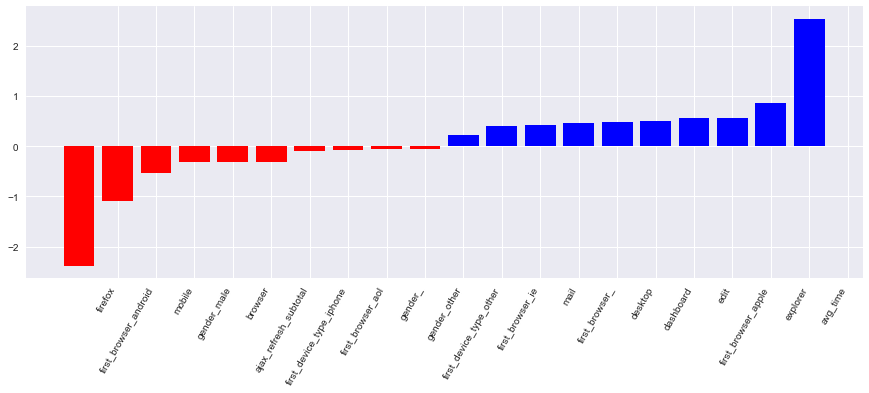

In [56]:
plot_coefficients(svm, cv.get_feature_names())
#the plot provides useful insight into what features are being used by the model to make the positive and negative classifications. 
#blue signifies variables that have positive effect at predicting isNDF = True, means no booking for that user?

### <a id="tune">Parameter Tuning </a>

**Steps**

Goal is to find the optimal softening parameter C (useful when data has some amount of overlap)

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as C. For very large C, the margin is hard, and points cannot lie in it. For smaller C, the margin is softer, and can grow to encompass some points.

Calculate the mean of cv error to get the final CV AUC

In [66]:
def parameter_tuning(model, X_train, y_train, param_grid, fold=5):   
    """
    Tune SVM's c parameter
    
    Parameters
    ----------
    model: sklearn's SVM Linear SVC model
    
    X_train: pandas DataFrame
        Preprocessed training data. Note that all the columns should be in numeric format.
    
    y_train: pandas Series
    
    param_grid: dict
        contains all the parameters that we want to tune for the responding model.    
        
    Note
    ----------
    * we use kfold in GridSearchCV in order to make sure the CV Score is consistent with the score 
      that we get from all the other function, including fit_bagging, fit_randomforest and fit_gbm. 
    * We use model_selection.KFold with fixed seed in order to make sure GridSearchCV uses the same seed as model_selection.cross_val_score.
    
    """
    seed=SEED
    
#     if 'n_estimators' in param_grid:
#         model.set_params(warm_start=True) 
    
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    svm_model = GridSearchCV(model, param_grid, cv=kfold, scoring='roc_auc')
    svm_model.fit(X_train, y_train)
    
    # best hyperparameter setting
    print('best parameters:{}'.format(svm_model.best_params_)) 
    print('best score:{}'.format(svm_model.best_score_)) 
    
    # refit model on best parameters
    model.set_params(**svm_model.best_params_)
    model.fit(X_train, y_train)

    return(model)

In [71]:
svm =  LinearSVC(random_state=SEED)

params = {
    'C': [0.1,0.5,1,5,10],
}

In [72]:
svm_final = parameter_tuning(svm, x, y, params)

best parameters:{'C': 0.1}
best score:0.7227873041211705


In [17]:
svm_final

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=480,
              presort='auto', random_state=12345, subsample=1.0, verbose=0,
              warm_start=False)

In [73]:
#CV misclass rate
scores = cross_val_score(svm_final, x, y, cv=5)
avg_missclass = sum(1-i for i in scores)/5
avg_misclass

0.32488163037349765

## <a id="refer">Reference</a>

* [Support vector machines](http://scikit-learn.org/stable/modules/svm.html#classification)
* [in-depth understanding on SVM](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
* [cross validation to tune parameters](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9598&rep=rep1&type=pdf

http://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf